# pre-requesties #

In [20]:
import time as tt
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
# from numba import njit, prange
# from numba import njit, prange


# 1D: Full Construction #

In [2]:

def fc(a,j,L):
    spin = np.array([[0,1],[1,0]]), np.array([[0,-1j],[+1j,0]]), np.array([[1,0],[0,-1]]) 
    
    out = 1
    
    for _ in range(j-1):
        #JW = np.kron(np.eye(2**(j-1)), np.kron(spin[abs(int(a)-1)], np.eye(2**(L-j))))
        out = np.kron(out,spin[2])
    
    op = 0.5*(spin[0]+a*1j*spin[1])
    # out = np.kron(out, np.kron(op, np.eye(2**(L-np.mod(j,L)-1))))
    out = np.kron(out, np.kron(op, np.eye(2**(L-j))))
    
    return out


def fermion_ham(V, L, J=1, BC=True):
    out = np.zeros((2**L,2**L), dtype=np.complex_)
    
    for n in range(1,L):
        
        out += -J*fc(+1,n,L) @ fc(-1,n+1,L) 
        out += -J*fc(+1,n+1,L) @ fc(-1,n,L)
        out += +0.5*V*( fc(+1,n,L) @ fc(-1,n,L) @ fc(+1,n+1,L) @ fc(-1,n+1,L))
        
    if BC:
        out += -J*fc(+1,L,L) @ fc(-1,1,L) 
        out += -J*fc(+1,1,L) @ fc(-1,L,L)
        out += +0.5*V*( fc(+1,L,L) @ fc(-1,L,L) @ fc(+1,1,L) @ fc(-1,1,L) )
    
    return out 


def full_total_particle_counts(L):
    
    out = np.zeros((2**L,2**L), dtype=np.complex_)  
    for n in range(1,L+1):    
        out += fc(+1,n,L) @ fc(-1,n,L)     
    
    return out


def full_particle_counts(input_state,L):
    
    input_state = np.array(input_state)
    # N = np.zeros((2**L,2**L), dtype=np.complex_) 
    Ns = np.zeros((L,) ) 
    for n in range(1,L+1):    
        n_th = fc(+1,n,L) @ fc(-1,n,L) 
        Ns[int(n-1)] += input_state @ n_th @ input_state.conj()
        
    return Ns


def ising_ham(parameters, L, **kws):    
    PBC = kws['PBC'] if 'PBC' in kws.keys() else False

    J, h = parameters[:2] 
    Sx, Sz = np.array([[0, 1], [1, 0]]), np.array([[1, 0],[0, -1]])

    H = np.zeros((2**L, 2**L))
    for l in range(1, L):
        H += J*np.kron(np.eye(2**(l-1)), np.kron(Sx, np.kron(Sx, np.eye(2**(L-l-1)))))
        H += -h*np.kron(np.eye(2**(l-1)), np.kron(Sz, np.eye(2**(L-l))))     
    H += -h*np.kron(np.eye(2**(L-1)), Sz)
    
    if PBC:
        H += J*np.kron(Sx, np.kron(np.eye(2**(L-2)), Sx))
    
    return H 

# 1D: Sector Construction #

In [3]:
def bit_flip(input, indx1, indx2):
    temp_state = np.array(input[:])
    temp_state[ [indx1,indx2] ] = 1 - temp_state[ [indx1,indx2] ]
    return temp_state


def acting_ham(n:int, physical, L:int, **kwargs):
    PBC = kwargs['PBC'] if 'PBC' in kwargs.keys() else True
    
    V, J = physical
    
    state = []
    weight = []
    # state_weight = []
    
    bin_state = np.array([int(i) for i in np.binary_repr(n, width=L)])
    rolo_state = np.roll(bin_state, -1)
    # diag = - 0.5 * V * (4* rolo_state @ bin_state - 4*sum(bin_state) + L)
    if PBC:
        diag = 0.5 * V * ( rolo_state @ bin_state )
    else:
        diag = 0.5 * V * ( rolo_state[:-1] @ bin_state[:-1] )
        
    # state_weight.append((n, float(diag)))
    state.append(n)
    weight.append(float(diag))
    # condi = np.bitwise_xor(bin_state,np.roll(bin_state,-1))
    for l in range(L - int(not PBC)):
        if bin_state[ l ] != rolo_state[ l ]:
            new_state = bit_flip(bin_state, np.mod(l,L), np.mod(l+1,L))
            m = int("".join(str(i) for i in new_state),2)
            # sign_factor = int( abs(n-m)/( 2**(L-1)-1 ) )
            # state_weight.append(( m ,-1.0*J*(-1)**sign_factor ))
            sign_factor = -1 if sum(bin_state) % 2 ==0 and int(abs(n-m)/(2**(L-1)-1))==1 else +1
            state.append( m )
            weight.append(J * sign_factor )
            # state_weight.append(( m , 1.0 * J * sign_factor ))

    # return state_weight
    return state, weight


def basis_set_N(N,L):
    
    basis_N = []
    # for n in range(2**L):
    for n in range(2**(L//2)-1,2**L - 2**(L//2) +1):
        bin_state = np.array([int(i) for i in np.binary_repr(n, width=L)])
        if sum(bin_state) == N:
            basis_N.append(n)
        
    return basis_N


def build_hamiltonian(L, parameters, **kwargs):
    sector = kwargs['sector'] if 'sector' in kwargs.keys() else L//2

    basis_N = basis_set_N(sector,L)
    HN = np.zeros( (np.size(basis_N), np.size(basis_N)) )
    
    for ind1, n in enumerate(basis_N):
        # for m, w in acting_ham(n,V,J,L):
        out_states, out_weights = acting_ham(n,parameters, L, **kwargs)
        # print(np.shape(out_weights), out_weights)
        for ii, m in enumerate(out_states):
            ind2 = basis_N.index(m)
            HN[ind2, ind1] += out_weights[ii]
            # print(n,",",m," -> (", ind2,",",ind1,") -> ", out_weights[ii])
                    
    return HN


def basis_set_NK(N,K,L): #not completed yet
    
    basis_NK = []
    for n in basis_set_N(N,L):
        # print( "-", n)
        bit_n = np.array([int(i) for i in np.binary_repr(n, width=L)])
        bit_m = [np.roll(bit_n, -i) for i in range(L)]
        # m = np.min( [int("".join(str(i) for i in bit),2) for bit in bit_m] )
        m = [int("".join(str(i) for i in bit),2) for bit in bit_m]
        # print( "  -", m)
        # bin_state = np.array([int(i) for i in np.binary_repr(n, width=L)])
        # if sum(bin_state) == N:
        #     basis_NK.append(n)
        
    return 


def particle_count(L, parameters, K = 2, **kwargs):
    sector = kwargs['sector'] if 'sector' in kwargs.keys() else L//2

    # energies, vectors = np.linalg.eigh(build_hamiltonian(N,L,parameters)) 
    energies, vectors = sp.linalg.eigh(build_hamiltonian(L,parameters, **kwargs), subset_by_index=[0,K-1]) 
    
    particle_stat = np.zeros((K,L))
    for w, n in enumerate(basis_set_N(sector,L)):
        for k in range(K):
            particle_stat[k,:] += (np.conjugate(vectors[w,k])*vectors[w,k]) * np.array([int(i) for i in np.binary_repr(n, width=L)])
    
    return particle_stat, energies


In [5]:
L = 4

bb = np.array(basis_set_N(L//2,L))
print(len(bb))
print("")

Vv, Jj = 0.2, 1.0
# print("PBC-Sector")
# outPut0 = build_hamiltonian(L,(Vv, Jj), PBC=True)
# print(np.real(np.sort( np.linalg.eigvals(outPut0))[:10]))
# print("")

# print("PBC-Full")
# outPut1 = fermion_ham(Vv, L, J=Jj, BC=True)
# print(np.real(np.sort( np.linalg.eigvals(outPut1))[:10]))
# print("")

print("OBC-Sector")
outPut1 = build_hamiltonian(L, (Vv, Jj), PBC=False)
# print(np.real(np.sort( np.linalg.eigvalsh(outPut1))[:10]))
print(np.sort( np.linalg.eigvalsh(outPut1))[0])
print( np.linalg.eigh(outPut1)[0][0])
print("")

# print("OBC-Full")
# outPut1 = fermion_ham(Vv, L, J=Jj, BC=False)
# print(np.real(np.sort( np.linalg.eigvalsh(outPut1))[:25]))
# print("")


6

OBC-Sector
-2.206796207188598
-2.206796207188598



In [34]:
L = 10

jj, hh = 1.0, 0.789
print("OBC-Sector")
outPut2 = ising_ham([jj, hh], L, PBC=False)
# print(outPut2)
print(np.real(np.sort( np.linalg.eigvalsh(outPut2)))[:10])
print("")


OBC-Sector
[-11.00540302 -10.93271397 -10.18531897 -10.11262992  -9.68605082
  -9.61336177  -9.20889529  -9.13620624  -8.86596677  -8.79327773]



# 2D: Full Construction #

In [41]:

def fc(a,j,L):
    spin = np.array([[0,1],[1,0]]), np.array([[0,-1j],[+1j,0]]), np.array([[1,0],[0,-1]]) 
    
    out = 1
    
    for _ in range(j-1):
        #JW = np.kron(np.eye(2**(j-1)), np.kron(spin[abs(int(a)-1)], np.eye(2**(L-j))))
        out = np.kron(out,spin[2])
    
    op = 0.5*(spin[0]+a*1j*spin[1])
    # out = np.kron(out, np.kron(op, np.eye(2**(L-np.mod(j,L)-1))))
    out = np.kron(out, np.kron(op, np.eye(2**(L-j))))
    
    return out


def Fermi_Hubbard_Ham_2d(physical, dims, **kwargs):
    PBC = kwargs.get('PBC', False)

    V, J = physical[:2] 
    Lx, Ly = dims
    
    Hy = np.eye(Ly, k=1, dtype=np.complex64) + np.eye(Ly, k=-1, dtype=np.complex64)  + int(PBC)*np.eye(Ly, k=Ly-1, dtype=np.complex64)  + int(PBC)*np.eye(Ly, k=-Ly+1, dtype=np.complex64)    
    Hx = np.eye(Lx, k=1, dtype=np.complex64) + np.eye(Lx, k=-1, dtype=np.complex64)  + int(PBC)*np.eye(Lx, k=Lx-1, dtype=np.complex64)  + int(PBC)*np.eye(Lx, k=-Lx+1, dtype=np.complex64)    
    adj_mat = np.kron(Hy, np.eye(Lx, dtype=np.complex64)) + np.kron(np.eye(Ly, dtype=np.complex64), Hx)

    
    L = Lx*Ly
    out = np.zeros((2**L,2**L), dtype=np.complex64)
    
    for xx in range(1, L+1):
        for yy in range(xx, L+1):
            out += -J * adj_mat[xx-1,yy-1] * (fc(+1,xx,L) @ fc(-1,yy,L) + fc(+1,yy,L) @ fc(-1,xx,L))
            out += +V/2 * adj_mat[xx-1,yy-1] * ( fc(+1,xx,L) @ fc(-1,xx,L) ) @ ( fc(+1,yy,L) @ fc(-1,yy,L) )
    
    return out 


def full_total_particle_counts(dims):
    
    Lx, Ly = dims
    L = Lx * Ly
    out = np.zeros((2**L,2**L), dtype=np.complex_)  
    for n in range(1,L+1):    
        out += fc(+1,n,L) @ fc(-1,n,L)     
    
    return out.real


def state_particle_count(input_state,L):
    
    input_state = np.array(input_state)
    # N = np.zeros((2**L,2**L), dtype=np.complex_) 
    Ns = np.zeros((L,) ) 
    for n in range(1,L+1):    
        n_th = fc(+1,n,L) @ fc(-1,n,L) 
        Ns[int(n-1)] += (input_state @ n_th @ input_state.conj() ).real
        
    return Ns


def sector_indexes(dims, EVs):
    
    Lx, Ly = dims
    sctr_indxs = [[] for _ in range(Lx*Ly+1)]
    for n in range(2**(Lx*Ly)):
        pcns = state_particle_count(EVs[:,n], Lx*Ly)
        tpcns = np.round(np.sum(pcns), decimals=0)
        sctr_indxs[int(tpcns)].append(n)
        
    return sctr_indxs


def green_operator(indxs, dims, U_t):
    """
    Calculate the Green's function for the Fermi-Hubbard ground state.
    Returns:
    numpy.ndarray: Green's function matrix.
    """
    Lx, Ly = dims
    L = Lx * Ly
    
    ii, jj = indxs

    return U_t @ fc(+1, ii, L) @ U_t.T.conj() @ fc(-1, jj, L)


def green_matrix(dims, U_t, state):
    
    Lx, Ly = dims
    L = Lx*Ly
    
    out_mat = np.zeros((L,L), dtype=np.complex128) 
    for xx in range(L):
        for yy in range(L):
            out_mat[xx,yy] += state @ green_operator( (xx+1,yy+1), dims, U_t) @ state.conj()
    
    return out_mat


# def single_correlation_matrix(dims, in_state):
#     Lx, Ly = dims
#     L = Lx*Ly
    
#     out_mat = np.zeros((L,L), dtype=np.complex128) 
#     for xx in range(L):
#         for yy in range():
#             out_mat[xx,yy] += in_state @ fc(+1, xx+1, L) @ fc(-1, yy+1, L) @ in_state.conj()
    
#     return out_mat


# def cross_correlation_matrix(dims, in_state):
#     Lx, Ly = dims
#     L = Lx*Ly
    
#     out_mat = np.zeros((L,L), dtype=np.complex128) 
#     for xx in range(L):
#         for yy in range():
#             out_mat[xx,yy] += in_state @ fc(+1, xx+1, L) @ fc(-1, yy+1, L) @ in_state.conj()
#             out_mat[xx,yy] -= in_state @ fc(+1, xx+1, L) @ fc(-1, yy+1, L) @ in_state.conj()
    
#     return out_mat



# def ising_ham_2d(parameters, L, **kws):    
#     PBC = kws['PBC'] if 'PBC' in kws.keys() else False

#     J, h = parameters[:2] 
#     Sx, Sz = np.array([[0, 1], [1, 0]]), np.array([[1, 0],[0, -1]])
    
#     return 0.0 *J *h

## Green's function time evoulution ##

Hamiltoni size: (64, 64) -> 64

eigen value time: 0.0020012855529785156

len of half filled sector: 20

ground state index: 0

  - - output: (0.35348863286588145+0j)
  + + G  mat: (0.35348863286588145+0j)
  * * N  mat: 0j

  - - output: (0.3478393615276845+0.05063400649664962j)
  + + G  mat: (0.3478393615276845+0.05063400649664962j)
  * * N  mat: 0.001023140821039898j

  - - output: (0.3312363324249862+0.09852193130522119j)
  + + G  mat: (0.3312363324249862+0.09852193130522119j)
  * * N  mat: 0.002046281642079796j

  - - output: (0.30469210489964915+0.14108856780780096j)
  + + G  mat: (0.30469210489964915+0.14108856780780096j)
  * * N  mat: 0.0030694224056907957j

  - - output: (0.2698240341279554+0.1760897170954548j)
  + + G  mat: (0.2698240341279554+0.1760897170954548j)
  * * N  mat: 0.004092563284159592j

  - - output: (0.22875331367336466+0.20175151768768915j)
  + + G  mat: (0.22875331367336466+0.20175151768768915j)
  * * N  mat: 0.005115704047770592j

  - - output: (0.183972691141

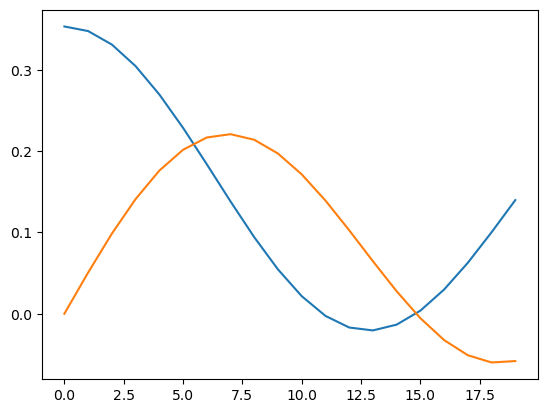

In [49]:
V, J = 0.11, 1.0

Lx, Ly = 3, 2
L = Lx*Ly

ii, jj = 1, 2

ham = Fermi_Hubbard_Ham_2d( (V, J), (Lx, Ly), PBC = False)
print("Hamiltoni size:", np.shape(ham),"->", 2**(Lx*Ly))
print("")

t0 = tt.time()
ee, vv = np.linalg.eigh(ham)
print("eigen value time:", tt.time()-t0)
print("")

sctrs = sector_indexes((Lx,Ly), vv)
# print("all sectord:", sctrs)
print("len of half filled sector:", len(sctrs[int(Lx*Ly/2)]))
print("")

gs_ind = sctrs[int(Lx*Ly/2)][0]
gs_vec = vv[:,gs_ind]
print("ground state index:", gs_ind)
print("")
# gs = vv[:,]

 
time_array = np.linspace(0, 2, num = 20)
out_real = []
out_imag = []
for time in time_array:
    ev_t = np.exp(-1j*ee*time)
    # U_t = np.linalg.multi_dot([vv, np.diag(ev_t), np.conjugate(np.transpose(vv)) ])
    U_t = vv @ np.diag(ev_t) @ vv.T.conj()
    
    # op_t = np.linalg.multi_dot([U_t, fc(+1, ii, L), np.conjugate(np.transpose(U_t))])
    op_t = U_t @ fc(+1, ii, L) @ U_t.T.conj()
    green_func = op_t @ fc(-1, jj, L)
    
    out_val = gs_vec @ green_func @ gs_vec.conj()
    print("  - - output:", out_val)
    out_real.append(out_val.real)
    out_imag.append(out_val.imag)

    G_Mat = green_matrix((Lx, Ly), U_t, gs_vec)
    print("  + + G  mat:", G_Mat[ii-1, jj-1])
    
    val0 = 1.0 * gs_vec @ fc(+1, ii, L) @ fc(-1, jj, L) @ gs_vec.conj()
    val1 = 1j*J*time * gs_vec @ fc(+1, ii, L) @ fc(-1, jj+1, L) @ gs_vec.conj()
    val2 = 1j*J*time * gs_vec @ fc(+1, ii, L) @ fc(-1, jj-1, L) @ gs_vec.conj()
    val3 = +0.5*1j*V*time * gs_vec @ fc(+1, ii, L) @ fc(-1, jj, L) @ fc(+1, jj+1, L) @ fc(-1, jj+1, L) @ gs_vec.conj()
    val4 = -0.5*1j*V*time * gs_vec @ fc(+1, ii, L) @ fc(-1, jj, L) @ fc(+1, jj-1, L) @ fc(-1, jj-1, L) @ gs_vec.conj()
    # print("  * * N  mat:", val0-val1-val2-val3-val4)
    print("  * * N  mat:", +val3-val4)
    print("")


print("Green's function matrix:")
print("")
# print(G)
plt.plot(out_real, label="Re")
plt.plot(out_imag, label="Im")

## testing stuff ##

In [60]:
V, J = 0.31, 1.0
Lx, Ly = 3, 2

ham = Fermi_Hubbard_Ham_2d( (V, J), (Lx, Ly), PBC = False)
print("Hamiltoni size:", np.shape(ham),"->", 2**(Lx*Ly))
print("")

ee, vv = np.linalg.eigh(ham)

print(" all energies are:")
print(ee[:20])
print("")

# e0 = [ [] for _ in range(L)]
sector_indxs = [[] for _ in range(Lx*Ly+1)]
for n in range(2**(Lx*Ly)):
    # print("   - shape:", np.shape(vv[:,n]))
    # print("   - state count:", n)
    pcns = state_particle_count(vv[:,n], Lx*Ly)
    tpcns = np.round(np.sum(pcns), decimals=0)
    # print("   - total count:", tpcns)
    sector_indxs[int(tpcns)].append(n)
    
    # if np.round(tpcns - Lx*Ly/2, decimals=5) == 0.0:
    #     e0.append(ee[n])
    #     zero_index.append(n)
        
print(" sector energies are:", len(ee[sector_indxs[4]]))
print(ee[sector_indxs[4]])
print("")
        


Hamiltoni size: (64, 64) -> 64

 all energies are:
[-3.6582928  -3.3765693  -2.9891102  -2.8487885  -2.7716844  -2.4636416
 -2.4142137  -2.2375362  -2.128017   -1.924001   -1.7188355  -1.6566584
 -1.614001   -1.3388355  -1.3388355  -1.         -0.9576823  -0.94921356
 -0.7714221  -0.7652565 ]

 sector energies are: 15
[-2.9891102  -2.4636416  -1.614001   -0.9576823  -0.94921356 -0.16063969
  0.4043988   0.465       0.56397986  1.0131809   1.8792136   1.8876823
  2.389001    3.200263    3.8415692 ]



# *2D:* sector construction # 

In [2]:
def bit_flip_2D(input, indxs1:tuple, indxs2:tuple):
    temp_state = np.array(input[:])
    temp_state[indxs1] = 1 - temp_state[indxs1]
    temp_state[indxs2] = 1 - temp_state[indxs2]
    return temp_state


# def basis_set_2D(L):
#     N = L//2
#     basis_N = []
#     for n in range(2**L):
#         bin_state = np.array([int(i) for i in np.binary_repr(n, width=L)[::-1]])
#         if sum(bin_state) == N:
#             basis_N.append(n)
#     return basis_N


def basis_set_2D(L, inversion = False):
    # *comment: for now, inversion does not work becuase it should be first Reflection resolved and then Inversion resolved.
    #           Not sure why!
    N = L // 2
    basis_N = []
    
    for n in range(2**N - 1, 2**L):
        bin_state = np.array([int(i) for i in np.binary_repr(n, width=L)])
        if sum(bin_state) == N:
            inv_n = 0.5
            if inversion == True:
                inv_state = np.ones(L,dtype=np.int32) - bin_state 
                inv_n = int("".join(str(i) for i in inv_state), 2)
            if inv_n not in basis_N:
                basis_N.append(n)
            # if n not in basis_N: #Positive Inversion sector!  
                # basis_N.append(inv_n)
    return basis_N


def acting_ham_2D(n:int, dims:tuple, *physical, **kwargs):
    PBC = kwargs['PBC'] if 'PBC' in kwargs.keys() else True

    Lx, Ly = dims
    V, J = physical[:2]
    state_weight = []
    # state_weight = {} #~~for~dict~version~~#
    
    bin_state = np.array([int(i) for i in np.binary_repr(n, width = Lx*Ly)[::-1]]).reshape(Ly,Lx)
    
    diag = 0
    if PBC:
        for ly in range(Ly):
            rolled = np.roll(bin_state[ly,:], -1)
            diag += - 0.5 * V * (rolled @ bin_state[ly,:])
            diag += - 0.5 * V * (bin_state[ly,:] @ bin_state[np.mod(ly+1,Ly),:])
        # if Ly == 2:
        #     diag += + 0.5 * V * (bin_state[ly,:] @ bin_state[np.mod(ly+1,Ly),:])
    else:
        for ly in range(Ly):
            rolled = np.roll(bin_state[ly,:], -1)
            diag += - 0.5 * V * (rolled[:-1] @ bin_state[ly,:-1])
        for ly in range(Ly - 1):
            diag += - 0.5 * V * (bin_state[ly,:] @ bin_state[ly+1,:])
        # if Ly == 2:
        #     diag += + 0.5 * V * (bin_state[ly,:] @ bin_state[ly+1,:])
            
    state_weight.append([n, diag])
    # state_weight[n] = diag #~for~dict~version~#
    
    # for yy in range(Ly - int(not PBC)):
    #     for xx in range(Lx - int(not PBC)):
    #         indx1 = (yy,xx)
    #         indx2 = (yy,np.mod(xx+1,Lx))
    #         if bin_state[indx1] != bin_state[indx2]:
    #             new_state = bit_flip_2D(bin_state, indx1, indx2)
    #             m = int("".join(str(i) for i in new_state.reshape(-1)[::-1] ), 2)
    #             st,nd = sorted( (indx1[1]+Lx*indx1[0], indx2[1]+Lx*indx2[0]) )               
    #             sign_factor = sum(bin_state.reshape(-1)[st+1:nd]) #int( 0 )
    #             if m not in np.transpose(state_weight)[0]:              
    #                 state_weight.append( [m ,-J*(-1)**sign_factor] )
    #             # if m not in state_weight.keys(): #~for~dict~version~#
    #             #     state_weight[m] = -1.0*J*(-1)**sign_factor
            
    #         indx2 = (np.mod(yy+1,Ly),xx)
    #         if bin_state[indx1] != bin_state[indx2]:
    #             new_state = bit_flip_2D(bin_state, indx1, indx2)
    #             m = int("".join(str(i) for i in new_state.reshape(-1)[::-1] ), 2)
    #             st,nd = sorted( (indx1[1]+Lx*indx1[0], indx2[1]+Lx*indx2[0]) )                
    #             sign_factor = sum(bin_state.reshape(-1)[st+1:nd]) #int( 0 )
    #             if m not in np.transpose(state_weight)[0]:             
    #                 state_weight.append( [m ,-J*(-1)**sign_factor] )
    #             # if m not in state_weight.keys(): #~for~dict~version~#
    #             #     state_weight[m] = -1.0*J*(-1)**sign_factor

    
    for yy in range(Ly):
        for xx in range(Lx - int(not PBC)):
            indx1, indx2 = (yy,xx), (yy,np.mod(xx+1,Lx))
            if bin_state[indx1] != bin_state[indx2]:
                new_state = bit_flip_2D(bin_state, indx1, indx2)
                m = int("".join(str(i) for i in new_state.reshape(-1)[::-1] ), 2)
                st,nd = sorted( (indx1[1]+Lx*indx1[0], indx2[1]+Lx*indx2[0]) )               
                sign_factor = sum(bin_state.reshape(-1)[st+1:nd]) #int( 0 )
                if m not in np.transpose(state_weight)[0]:              
                    state_weight.append( [m ,-J*(-1)**sign_factor] )
                # if m not in state_weight.keys(): #~for~dict~version~#
                #     state_weight[m] = -1.0*J*(-1)**sign_factor
            
    for yy in range(Ly - int(not PBC)):
        for xx in range(Lx):
            indx1, indx2 = (yy,xx), (np.mod(yy+1,Ly),xx)
            if bin_state[indx1] != bin_state[indx2]:
                new_state = bit_flip_2D(bin_state, indx1, indx2)
                m = int("".join(str(i) for i in new_state.reshape(-1)[::-1] ), 2)
                st,nd = sorted( (indx1[1]+Lx*indx1[0], indx2[1]+Lx*indx2[0]) )                
                sign_factor = sum(bin_state.reshape(-1)[st+1:nd]) #int( 0 )
                if m not in np.transpose(state_weight)[0]:             
                    state_weight.append( [m ,-J*(-1)**sign_factor] )
                # if m not in state_weight.keys(): #~for~dict~version~#
                #     state_weight[m] = -1.0*J*(-1)**sign_factor

    return state_weight


def build_hamiltonian_2D(dims:tuple, *physical_parameter, **kwargs):
    
    Lx, Ly = dims
    basis_2D = basis_set_2D( Lx*Ly )
    # basis_2D = [n for n in range(2**(Lx*Ly)) ]
    HAM = np.zeros( (np.size(basis_2D), np.size(basis_2D)) )
    for ind1, n in enumerate(basis_2D):

        out_state_weight = acting_ham_2D(n,dims,*physical_parameter,**kwargs)
        for m in out_state_weight:
            # if int(m[0]) in basis_2D:
            ind2 = basis_2D.index(int(m[0]))
            HAM[ind2, ind1] += m[1]
                    
    return HAM



Lx, Ly = 4, 3
VV, JJ = 3.571, 1.0 
# lissbin = np.array([int(i) for i in np.binary_repr(16, width = Lx*Ly)[::-1]]).reshape(Ly,Lx)
# print(basis_set_2D(Lx*Ly))
# bit_flip_2D(lissbin,(1,1),(2,1))
# aa = [ float(acting_ham_2D(nn, (Lx, Ly) ,1,0,8)[0][1]) for nn in range(2**(Lx*Ly))]
# print(aa[::-1])

# xx = acting_ham_2D(63, (Lx, Ly) ,.31415,1,8)
# acting_ham_2D(16, (Lx, Ly) ,1,1,8)


test = build_hamiltonian_2D( (Lx,Ly), VV, JJ, PBC=False)
print(len(test),"-",len(basis_set_2D(Lx*Ly)))
ee = np.linalg.eigvalsh(test)
print(list(ee[:20]))
print(list(ee[-20:]))
# print('\n')
# print(test[1:12,1:12])
# print(list(np.diag(test)))

NameError: name 'np' is not defined

In [13]:
def basis_set_2D(L, inversion = False):
    N = L//2
    basis_N = []
    for n in range(2**L):
        inv_n = 0.5
        bin_state = np.array([int(i) for i in np.binary_repr(n, width=L)[::-1]])
        
        if inversion == True:
            inv_state = np.ones(L,dtype=np.int32) - bin_state 
            inv_n = int("".join(str(i) for i in inv_state), 2)
                
        if sum(bin_state) == N and inv_n not in basis_N:
            basis_N.append(n)
        
    return basis_N

def basis_set_2D_I(L):
    N = L//2
    basis_N = []
    for n in range(2**L):
        bin_state = np.array([int(i) for i in np.binary_repr(n, width=L)[::-1]])
        inv_state = np.ones(L,dtype=np.int32) - bin_state 
        inv_n = int("".join(str(i) for i in inv_state), 2)
        if sum(bin_state) == N and inv_n not in basis_N:
            basis_N.append(n)
            # print(bin_state)
            # print(inv_state)
        
    return basis_N


Lx,Ly = 4,5
print(len(basis_set_2D(Lx*Ly))," - ",len(basis_set_2D_I(Lx*Ly)))

184756  -  92890
